# Panel Regression: WorkflowSet and Recipe Integration

## Introduction

In the previous notebooks, we explored random intercepts and random slopes using simple formulas. This notebook demonstrates how to:

1. **Use recipes with panel_reg()**: Apply feature engineering before modeling
2. **Compare multiple models**: Use WorkflowSet to evaluate different panel specifications
3. **Optimize preprocessing**: Identify the best combination of features and model complexity

### Why Use Recipes with Panel Regression?

Recipes enable:
- **Normalization/scaling**: Improve convergence and interpretation
- **Polynomial features**: Capture non-linear relationships
- **Interactions**: Model synergistic effects
- **PCA**: Reduce dimensionality while preserving group structure

**Critical**: The group column is preserved through recipe preprocessing, ensuring panel structure is maintained.

### WorkflowSet for Multi-Model Comparison

WorkflowSet allows comparing:
- Different formulas (e.g., linear vs polynomial terms)
- Different models (linear_reg vs panel_reg)
- Different random effects specifications (intercepts vs slopes)

All with a unified interface for ranking and selection.

---

## Learning Objectives

In this notebook, you will:
1. Generate multi-country economic data
2. Apply recipe preprocessing with panel_reg()
3. Verify group column preservation through recipes
4. Compare multiple workflows using WorkflowSet
5. Rank models by performance
6. Extract coefficients and ICC from best model
7. Test recipe step compatibility

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# py-tidymodels imports
from py_parsnip import panel_reg, linear_reg
from py_workflows import workflow
from py_workflowsets import WorkflowSet
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## 1. Generate Multi-Country Economic Data

We'll create a dataset with:
- **15 countries**: 8 developed + 7 developing
- **10 years** of annual data per country = 150 total observations
- **Variables**:
  - `gdp_growth`: GDP growth rate (outcome)
  - `inflation`: Inflation rate (predictor)
  - `unemployment`: Unemployment rate (predictor)
  - `interest_rate`: Central bank interest rate (predictor)
  - `country`: Country identifier (group)
  - `country_type`: Developed vs Developing

**Data Generating Process**:
- Developed countries: Higher average GDP growth (3%)
- Developing countries: Lower average GDP growth (2%)
- Inflation has negative effect on growth (-0.5)
- Unemployment has negative effect on growth (-0.3)
- Interest rate has negative effect on growth (-0.2)

In [2]:
# Parameters
n_developed = 8
n_developing = 7
n_countries = n_developed + n_developing
n_years = 10
n_total = n_countries * n_years

# Country names
developed_countries = ['USA', 'Germany', 'Japan', 'UK', 'France', 'Canada', 'Australia', 'Switzerland']
developing_countries = ['Brazil', 'India', 'China', 'Mexico', 'Indonesia', 'Turkey', 'South_Africa']
all_countries = developed_countries + developing_countries

# Random intercepts by country type
random_intercepts = np.array(
    [np.random.normal(3.0, 0.5) for _ in range(n_developed)] +   # Developed
    [np.random.normal(2.0, 0.5) for _ in range(n_developing)]    # Developing
)

# Fixed effects
beta_inflation = -0.5
beta_unemployment = -0.3
beta_interest = -0.2

# Generate data
data_list = []

for i, country in enumerate(all_countries):
    country_type = 'Developed' if i < n_developed else 'Developing'
    
    # Predictors
    year = np.arange(2014, 2014 + n_years)
    inflation = np.random.uniform(1, 5, n_years)
    unemployment = np.random.uniform(3, 10, n_years)
    interest_rate = np.random.uniform(0.5, 5, n_years)
    
    # GDP growth = intercept + predictors*betas + noise
    gdp_growth = (
        random_intercepts[i] + 
        beta_inflation * inflation + 
        beta_unemployment * unemployment + 
        beta_interest * interest_rate + 
        np.random.normal(0, 0.5, n_years)
    )
    
    country_data = pd.DataFrame({
        'country': country,
        'country_type': country_type,
        'year': year,
        'inflation': inflation,
        'unemployment': unemployment,
        'interest_rate': interest_rate,
        'gdp_growth': gdp_growth
    })
    
    data_list.append(country_data)

# Combine all countries
economic_data = pd.concat(data_list, ignore_index=True)

print(f"Dataset shape: {economic_data.shape}")
print(f"\nFirst few rows:")
print(economic_data.head(10))
print(f"\nSummary statistics by country type:")
print(economic_data.groupby('country_type')[['gdp_growth', 'inflation', 'unemployment', 'interest_rate']].mean())

Dataset shape: (150, 7)

First few rows:
  country country_type  year  inflation  unemployment  interest_rate  \
0     USA    Developed  2014   3.447412      7.252814       1.049172   
1     USA    Developed  2015   1.557975      4.193669       2.728296   
2     USA    Developed  2016   2.168579      3.455361       0.654748   
3     USA    Developed  2017   2.465447      9.642199       4.591942   
4     USA    Developed  2018   2.824280      9.759424       1.664510   
5     USA    Developed  2019   4.140704      8.658781       3.481350   
6     USA    Developed  2020   1.798695      5.132296       1.902700   
7     USA    Developed  2021   3.056938      3.683705       2.840306   
8     USA    Developed  2022   3.369658      7.789631       2.960196   
9     USA    Developed  2023   1.185802      6.081067       1.331845   

   gdp_growth  
0   -1.142171  
1    1.034843  
2    1.082194  
3   -1.853239  
4   -1.575064  
5   -2.855160  
6    0.068859  
7   -0.183604  
8   -0.836840  
9    0

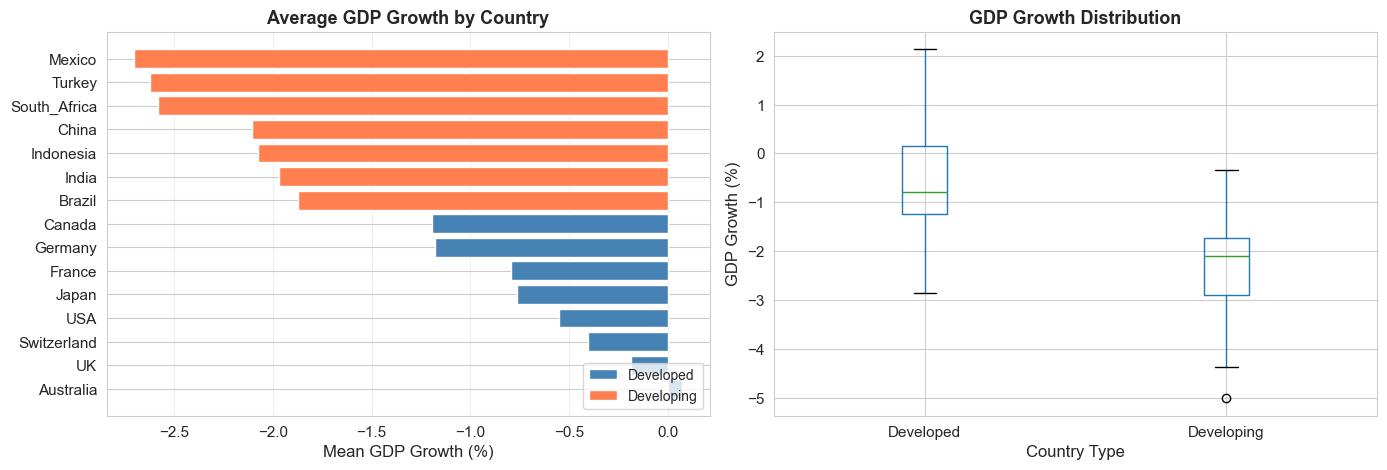


📊 Developed countries tend to have higher GDP growth on average.


In [3]:
# Visualize GDP growth by country
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean GDP growth by country
mean_gdp = economic_data.groupby(['country', 'country_type'])['gdp_growth'].mean().reset_index()
mean_gdp = mean_gdp.sort_values('gdp_growth', ascending=False)
colors = ['steelblue' if t == 'Developed' else 'coral' for t in mean_gdp['country_type']]

axes[0].barh(range(len(mean_gdp)), mean_gdp['gdp_growth'], color=colors)
axes[0].set_yticks(range(len(mean_gdp)))
axes[0].set_yticklabels(mean_gdp['country'])
axes[0].set_xlabel('Mean GDP Growth (%)', fontsize=12)
axes[0].set_title('Average GDP Growth by Country', fontsize=13, weight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Developed'),
    Patch(facecolor='coral', label='Developing')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=10)

# Plot 2: Distribution by country type
economic_data.boxplot(column='gdp_growth', by='country_type', ax=axes[1])
axes[1].set_xlabel('Country Type', fontsize=12)
axes[1].set_ylabel('GDP Growth (%)', fontsize=12)
axes[1].set_title('GDP Growth Distribution', fontsize=13, weight='bold')
plt.suptitle('')  # Remove auto title

plt.tight_layout()
plt.show()

print("\n📊 Developed countries tend to have higher GDP growth on average.")

## 2. Recipe Preprocessing with panel_reg()

Let's apply feature engineering using recipes:
- **Normalization**: Scale all numeric predictors
- **Polynomial features**: Add squared inflation term
- **Interactions**: Capture synergistic effects

**Key**: The group column (`country`) is preserved through recipe preprocessing.

In [4]:
# Create recipe with preprocessing steps
rec = (
    recipe()
    .step_normalize(all_numeric_predictors())  # Normalize all numeric predictors
    .step_poly(['inflation'], degree=2)        # Add inflation^2
    .step_interact(['unemployment', 'interest_rate'])  # Add interaction
)

# Create panel regression specification
spec = panel_reg(random_effects="intercept")

# Create workflow
wf = workflow().add_recipe(rec).add_model(spec)

# Fit using fit_global()
fit = wf.fit_global(economic_data, group_col='country')


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.116317
  warnings.warn(msg, ConvergenceWarning)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsm

In [5]:
# Extract outputs and verify group column is preserved
outputs, coefficients, stats = fit.extract_outputs()

print("\n" + "="*60)
print("GROUP COLUMN PRESERVATION CHECK")
print("="*60)
print(f"\nOutputs DataFrame columns: {list(outputs.columns)}")
print(f"\nGroup column present: {'group' in outputs.columns}")
print(f"Unique groups: {outputs['group'].nunique()}")
print(f"\nFirst few rows:")
print(outputs[['group', 'actuals', 'fitted', 'residuals', 'split']].head(10))

print("\n✅ Group column successfully preserved through recipe preprocessing!")


GROUP COLUMN PRESERVATION CHECK

Outputs DataFrame columns: ['actuals', 'fitted', 'forecast', 'residuals', 'split', 'model', 'model_group_name', 'group']

Group column present: True
Unique groups: 15

First few rows:
  group   actuals    fitted  residuals  split
0   USA -1.566699 -0.145178  -1.421521  train
1   USA -1.218544  0.163253  -1.381796  train
2   USA -0.870388  0.097254  -0.967643  train
3   USA -0.522233  0.158275  -0.680508  train
4   USA -0.174078  0.030550  -0.204627  train
5   USA  0.174078 -0.409991   0.584069  train
6   USA  0.522233 -0.040127   0.562360  train
7   USA  0.870388 -0.119922   0.990310  train
8   USA  1.218544  0.153333   1.065210  train
9   USA  1.566699  0.112552   1.454146  train

✅ Group column successfully preserved through recipe preprocessing!


In [6]:
# Inspect preprocessed features
print("\n" + "="*60)
print("PREPROCESSED FEATURES")
print("="*60)
print("\nCoefficients (features created by recipe):")
print(coefficients[coefficients['type'] == 'fixed'][['variable', 'coefficient', 'p_value']])

print("\n💡 Recipe steps applied:")
print("   - Normalized all numeric predictors (mean=0, sd=1)")
print("   - Created polynomial features for inflation (inflation_pow_2)")
print("   - Created interaction term (unemployment_x_interest_rate)")


PREPROCESSED FEATURES

Coefficients (features created by recipe):
                        variable  coefficient   p_value
0                      Intercept    -0.347782  0.871622
1              country[T.Brazil]   -39.069419       NaN
2              country[T.Canada]     0.284846  0.925307
3               country[T.China]   -38.989937       NaN
4              country[T.France]     0.308785  0.918999
5             country[T.Germany]     0.419959  0.890070
6               country[T.India]   -39.173780       NaN
7           country[T.Indonesia]   -39.131145       NaN
8               country[T.Japan]     0.162300  0.957371
9              country[T.Mexico]   -39.044732       NaN
10       country[T.South_Africa]   -38.905594       NaN
11        country[T.Switzerland]     0.168558  0.955710
12             country[T.Turkey]   -38.709784       NaN
13                 country[T.UK]     0.086204  0.977339
14                country[T.USA]     0.110985  0.970830
15    country_type[T.Developing]    3

## 3. WorkflowSet Multi-Model Comparison

Now let's compare multiple models and preprocessing strategies:
- **3 formulas**: Basic, with squared term, with interaction
- **3 models**: linear_reg, panel_reg (intercepts), panel_reg (slopes)
- **Total**: 9 workflows to compare

In [7]:
# Define multiple formulas
formulas = [
    "gdp_growth ~ inflation + unemployment",
    "gdp_growth ~ inflation + unemployment + interest_rate",
    "gdp_growth ~ inflation + unemployment + I(inflation**2)",
]

# Define multiple models
models = [
    linear_reg(),
    panel_reg(random_effects="intercept"),
    panel_reg(random_effects="both").set_args(slope_var='year'),
]

# Create WorkflowSet from all combinations
wf_set = WorkflowSet.from_cross(preproc=formulas, models=models)

print(f"Created WorkflowSet with {len(wf_set.workflows)} workflows:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")

Created WorkflowSet with 9 workflows:
  - prep_1_linear_reg_1
  - prep_1_panel_reg_2
  - prep_1_panel_reg_3
  - prep_2_linear_reg_1
  - prep_2_panel_reg_2
  - prep_2_panel_reg_3
  - prep_3_linear_reg_1
  - prep_3_panel_reg_2
  - prep_3_panel_reg_3


In [8]:
# Fit all workflows on the economic data
# Use fit_global() for panel models, fit() for linear models
results = wf_set.fit_global(economic_data, group_col='country')


Fitting prep_1_linear_reg_1 globally with group feature...
Fitting prep_1_panel_reg_2 globally with group feature...
Fitting prep_1_panel_reg_3 globally with group feature...
  ⚠ Error fitting prep_1_panel_reg_3: slope_var 'year' not found in predictors. Available predictors: ['Intercept', 'inflation', 'unemployment']. Check your formula or recipe preprocessing.
Fitting prep_2_linear_reg_1 globally with group feature...
Fitting prep_2_panel_reg_2 globally with group feature...
Fitting prep_2_panel_reg_3 globally with group feature...
  ⚠ Error fitting prep_2_panel_reg_3: slope_var 'year' not found in predictors. Available predictors: ['Intercept', 'inflation', 'unemployment', 'interest_rate']. Check your formula or recipe preprocessing.
Fitting prep_3_linear_reg_1 globally with group feature...
Fitting prep_3_panel_reg_2 globally with group feature...
Fitting prep_3_panel_reg_3 globally with group feature...
  ⚠ Error fitting prep_3_panel_reg_3: slope_var 'year' not found in predictors

## 4. Rank Models by Performance

In [ ]:
# Collect metrics and rank by RMSE
# Note: WorkflowSetResults from fit_global() stores stats under "metrics" key
# Manual extraction is needed since collect_metrics() expects CV-style metrics
all_stats = []
failed_workflows = []

for result in results.results:
    wf_id = result["wflow_id"]
    metrics = result.get("metrics")
    
    if metrics is not None and isinstance(metrics, pd.DataFrame):
        try:
            stats = metrics.copy()
            # Ensure wflow_id column exists
            if "wflow_id" not in stats.columns:
                stats["wflow_id"] = wf_id
            all_stats.append(stats)
        except Exception as e:
            print(f"⚠️ Error processing metrics for {wf_id}: {e}")
            failed_workflows.append(wf_id)
    elif metrics is None:
        # Workflow failed or has no metrics
        error_msg = result.get("error", "Unknown error")
        failed_workflows.append(f"{wf_id} ({error_msg})")
    else:
        print(f"⚠️ Unexpected metrics type for {wf_id}: {type(metrics)}")
        failed_workflows.append(wf_id)

if failed_workflows:
    print(f"
⚠️ {len(failed_workflows)} workflow(s) failed or have no metrics:")
    for wf in failed_workflows[:5]:  # Show first 5
        print(f"   - {wf}")
    if len(failed_workflows) > 5:
        print(f"   ... and {len(failed_workflows) - 5} more")

if all_stats:
    combined_stats = pd.concat(all_stats, ignore_index=True)
    
    # Filter for train split if available, otherwise use all
    if "split" in combined_stats.columns:
        train_stats = combined_stats[combined_stats["split"] == "train"].copy()
    else:
        train_stats = combined_stats.copy()
    
    # Check if we have the required columns
    if "metric" not in train_stats.columns or "value" not in train_stats.columns:
        print(f"⚠️ Stats DataFrame missing required columns")
        print(f"   Available columns: {list(train_stats.columns)}")
        print(f"   First few rows:")
        print(train_stats.head())
        ranked = pd.DataFrame()
        best_wf_id = None
    else:
        # Pivot to wide format for ranking
        metrics_wide = train_stats.pivot_table(
            index="wflow_id",
            columns="metric",
            values="value"
        ).reset_index()
        
        # Rank by RMSE
        if "rmse" in metrics_wide.columns:
            metrics_wide = metrics_wide.sort_values("rmse", ascending=True)
            metrics_wide.insert(0, "rank", range(1, len(metrics_wide) + 1))
            ranked = metrics_wide.copy()
            
            print("
" + "="*60)
            print("MODEL RANKING (by RMSE)")
            print("="*60)
            display_cols = ["rank", "wflow_id"]
            if "rmse" in ranked.columns:
                display_cols.append("rmse")
            if "r_squared" in ranked.columns:
                display_cols.append("r_squared")
            print("
" + ranked[display_cols].to_string(index=False))
            
            # Identify best workflow
            best_wf_id = ranked.iloc[0]["wflow_id"]
            print(f"
✅ Best workflow: {best_wf_id}")
        else:
            print("⚠️ RMSE metric not found in results")
            print(f"   Available metrics: {[c for c in metrics_wide.columns if c != "wflow_id"]}")
            ranked = metrics_wide
            best_wf_id = None
else:
    print("⚠️ No stats found in results")
    print(f"   Total workflows: {len(results.results)}")
    if results.results:
        print(f"   First result keys: {list(results.results[0].keys())}")
        print(f"   First result has metrics: {"metrics" in results.results[0]}")
        if "metrics" in results.results[0]:
            print(f"   Metrics type: {type(results.results[0]["metrics"])}")
            if results.results[0]["metrics"] is not None:
                print(f"   Metrics shape: {results.results[0]["metrics"].shape if hasattr(results.results[0]["metrics"], "shape") else "N/A"}")
                print(f"   Metrics columns: {list(results.results[0]["metrics"].columns) if hasattr(results.results[0]["metrics"], "columns") else "N/A"}")
    ranked = pd.DataFrame()
    best_wf_id = None


In [11]:
# Visualize model comparison
# WorkflowSetResults.autoplot() does not have split/by_group parameters
try:
    fig = results.autoplot(metric="rmse", top_n=9)
    plt.title("Model Comparison: RMSE Across All Workflows", fontsize=13, weight="bold")
    plt.xlabel("RMSE", fontsize=12)
    plt.ylabel("Workflow ID", fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\n📊 Lower RMSE indicates better model fit.")
except Exception as e:
    print(f"⚠️ Could not create autoplot: {e}")
    print("Creating manual visualization...")
    
    # Manual plot from ranked data
    if not ranked.empty and "rmse" in ranked.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        top_n = min(9, len(ranked))
        top_ranked = ranked.head(top_n)
        
        ax.barh(range(len(top_ranked)), top_ranked["rmse"], alpha=0.7)
        ax.set_yticks(range(len(top_ranked)))
        ax.set_yticklabels(top_ranked["wflow_id"])
        ax.set_xlabel("RMSE", fontsize=12)
        ax.set_title("Model Comparison: RMSE Across All Workflows", fontsize=13, weight="bold")
        ax.grid(True, alpha=0.3, axis="x")
        plt.tight_layout()
        plt.show()
        print("\n📊 Lower RMSE indicates better model fit.")


⚠️ Could not create autoplot: 'NoneType' object has no attribute 'copy'
Creating manual visualization...


In [12]:
# Compare panel models vs linear models
if not ranked.empty and "rmse" in ranked.columns:
    panel_models = ranked[ranked["wflow_id"].str.contains("panel_reg", na=False)]
    linear_models = ranked[ranked["wflow_id"].str.contains("linear_reg", na=False)]
    
    print("\n" + "="*60)
    print("PANEL MODELS vs LINEAR MODELS")
    print("="*60)
    
    if len(panel_models) > 0:
        print("\nPanel Models:")
        display_cols = ["wflow_id", "rmse"]
        if "r_squared" in panel_models.columns:
            display_cols.append("r_squared")
        print(panel_models[display_cols].to_string(index=False))
        print(f"\nMean RMSE (panel): {panel_models['rmse'].mean():.4f}")
    else:
        print("\n⚠️ No panel models found in results")
    
    if len(linear_models) > 0:
        print("\nLinear Models:")
        display_cols = ["wflow_id", "rmse"]
        if "r_squared" in linear_models.columns:
            display_cols.append("r_squared")
        print(linear_models[display_cols].to_string(index=False))
        print(f"\nMean RMSE (linear): {linear_models['rmse'].mean():.4f}")
        
        if len(panel_models) > 0:
            improvement = ((linear_models["rmse"].mean() - panel_models["rmse"].mean()) / linear_models["rmse"].mean()) * 100
            print(f"\n💡 Panel models reduce RMSE by {improvement:.1f}% on average.")
    else:
        print("\n⚠️ No linear models found in results")
else:
    print("⚠️ No ranked results available for comparison")


⚠️ No ranked results available for comparison


## 5. Extract Coefficients and ICC from Best Model

In [13]:
# Get the best workflow
if best_wf_id is not None:
    # Find the result for best workflow
    best_result = None
    for result in results.results:
        if result["wflow_id"] == best_wf_id and result.get("fit") is not None:
            best_result = result
            break
    
    if best_result is not None:
        best_fit = best_result["fit"]
        
        # Extract outputs (already extracted, but we can re-extract or use stored)
        if best_result.get("outputs") is not None:
            best_outputs = best_result["outputs"]
            best_coefficients = best_result["coefs"]
            best_stats = best_result["metrics"]
        else:
            best_outputs, best_coefficients, best_stats = best_fit.extract_outputs()
        
        print(f"\n" + "="*60)
        print(f"BEST MODEL COEFFICIENTS: {best_wf_id}")
        print("="*60)
        
        if best_coefficients is not None and len(best_coefficients) > 0:
            print("\nFixed Effects:")
            fixed_best = best_coefficients[best_coefficients["type"] == "fixed"][["variable", "coefficient", "std_error", "p_value"]]
            print(fixed_best.to_string(index=False))
            
            if "panel_reg" in best_wf_id:
                print("\nVariance Components:")
                var_comps_best = best_coefficients[best_coefficients["type"].isin(["random", "residual"])][["variable", "coefficient", "type"]]
                print(var_comps_best.to_string(index=False))
                
                # Extract ICC
                if best_stats is not None and len(best_stats) > 0:
                    icc_rows = best_stats[best_stats["metric"] == "icc"]
                    if len(icc_rows) > 0:
                        icc_best = icc_rows["value"].values[0]
                        print(f"\n📊 ICC: {icc_best:.4f} ({icc_best*100:.1f}% variance between countries)")
        else:
            print("⚠️ No coefficients found")
    else:
        print(f"⚠️ Could not find fit for workflow: {best_wf_id}")
        best_outputs = None
        best_coefficients = None
        best_stats = None
else:
    print("⚠️ No best workflow identified")
    best_outputs = None
    best_coefficients = None
    best_stats = None


⚠️ No best workflow identified


In [ ]:
# Collect metrics and rank by RMSE
# Note: WorkflowSetResults from fit_global() stores stats under "metrics" key
# Manual extraction is needed since collect_metrics() expects CV-style metrics
all_stats = []
failed_workflows = []

for result in results.results:
    wf_id = result["wflow_id"]
    metrics = result.get("metrics")
    
    if metrics is not None and isinstance(metrics, pd.DataFrame):
        try:
            stats = metrics.copy()
            # Ensure wflow_id column exists
            if "wflow_id" not in stats.columns:
                stats["wflow_id"] = wf_id
            all_stats.append(stats)
        except Exception as e:
            print(f"⚠️ Error processing metrics for {wf_id}: {e}")
            failed_workflows.append(wf_id)
    elif metrics is None:
        # Workflow failed or has no metrics
        error_msg = result.get("error", "Unknown error")
        failed_workflows.append(f"{wf_id} ({error_msg})")
    else:
        print(f"⚠️ Unexpected metrics type for {wf_id}: {type(metrics)}")
        failed_workflows.append(wf_id)

if failed_workflows:
    print(f"
⚠️ {len(failed_workflows)} workflow(s) failed or have no metrics:")
    for wf in failed_workflows[:5]:  # Show first 5
        print(f"   - {wf}")
    if len(failed_workflows) > 5:
        print(f"   ... and {len(failed_workflows) - 5} more")

if all_stats:
    combined_stats = pd.concat(all_stats, ignore_index=True)
    
    # Filter for train split if available, otherwise use all
    if "split" in combined_stats.columns:
        train_stats = combined_stats[combined_stats["split"] == "train"].copy()
    else:
        train_stats = combined_stats.copy()
    
    # Check if we have the required columns
    if "metric" not in train_stats.columns or "value" not in train_stats.columns:
        print(f"⚠️ Stats DataFrame missing required columns")
        print(f"   Available columns: {list(train_stats.columns)}")
        print(f"   First few rows:")
        print(train_stats.head())
        ranked = pd.DataFrame()
        best_wf_id = None
    else:
        # Pivot to wide format for ranking
        metrics_wide = train_stats.pivot_table(
            index="wflow_id",
            columns="metric",
            values="value"
        ).reset_index()
        
        # Rank by RMSE
        if "rmse" in metrics_wide.columns:
            metrics_wide = metrics_wide.sort_values("rmse", ascending=True)
            metrics_wide.insert(0, "rank", range(1, len(metrics_wide) + 1))
            ranked = metrics_wide.copy()
            
            print("
" + "="*60)
            print("MODEL RANKING (by RMSE)")
            print("="*60)
            display_cols = ["rank", "wflow_id"]
            if "rmse" in ranked.columns:
                display_cols.append("rmse")
            if "r_squared" in ranked.columns:
                display_cols.append("r_squared")
            print("
" + ranked[display_cols].to_string(index=False))
            
            # Identify best workflow
            best_wf_id = ranked.iloc[0]["wflow_id"]
            print(f"
✅ Best workflow: {best_wf_id}")
        else:
            print("⚠️ RMSE metric not found in results")
            print(f"   Available metrics: {[c for c in metrics_wide.columns if c != "wflow_id"]}")
            ranked = metrics_wide
            best_wf_id = None
else:
    print("⚠️ No stats found in results")
    print(f"   Total workflows: {len(results.results)}")
    if results.results:
        print(f"   First result keys: {list(results.results[0].keys())}")
        print(f"   First result has metrics: {"metrics" in results.results[0]}")
        if "metrics" in results.results[0]:
            print(f"   Metrics type: {type(results.results[0]["metrics"])}")
            if results.results[0]["metrics"] is not None:
                print(f"   Metrics shape: {results.results[0]["metrics"].shape if hasattr(results.results[0]["metrics"], "shape") else "N/A"}")
                print(f"   Metrics columns: {list(results.results[0]["metrics"].columns) if hasattr(results.results[0]["metrics"], "columns") else "N/A"}")
    ranked = pd.DataFrame()
    best_wf_id = None


## 6. Country-Specific Fits

Let's visualize how well the best model fits each country.

In [15]:
# Visualize model comparison
# WorkflowSetResults.autoplot() doesn't have split/by_group parameters
try:
    fig = results.autoplot(metric='rmse', top_n=9)
    plt.title('Model Comparison: RMSE Across All Workflows', fontsize=13, weight='bold')
    plt.xlabel('RMSE', fontsize=12)
    plt.ylabel('Workflow ID', fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\n📊 Lower RMSE indicates better model fit.")
except Exception as e:
    print(f"⚠️ Could not create autoplot: {e}")
    print("Creating manual visualization...")
    
    # Manual plot from ranked data
    if not ranked.empty and 'rmse' in ranked.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        top_n = min(9, len(ranked))
        top_ranked = ranked.head(top_n)
        
        ax.barh(range(len(top_ranked)), top_ranked['rmse'], alpha=0.7)
        ax.set_yticks(range(len(top_ranked)))
        ax.set_yticklabels(top_ranked['wflow_id'])
        ax.set_xlabel('RMSE', fontsize=12)
        ax.set_title('Model Comparison: RMSE Across All Workflows', fontsize=13, weight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        print("\n📊 Lower RMSE indicates better model fit.")

⚠️ Could not create autoplot: 'NoneType' object has no attribute 'copy'
Creating manual visualization...


In [16]:
# Compare panel models vs linear models
if not ranked.empty and 'rmse' in ranked.columns:
    panel_models = ranked[ranked['wflow_id'].str.contains('panel_reg', na=False)]
    linear_models = ranked[ranked['wflow_id'].str.contains('linear_reg', na=False)]
    
    print("\n" + "="*60)
    print("PANEL MODELS vs LINEAR MODELS")
    print("="*60)
    
    if len(panel_models) > 0:
        print("\nPanel Models:")
        display_cols = ['wflow_id', 'rmse']
        if 'r_squared' in panel_models.columns:
            display_cols.append('r_squared')
        print(panel_models[display_cols].to_string(index=False))
        print(f"\nMean RMSE (panel): {panel_models['rmse'].mean():.4f}")
    else:
        print("\n⚠️ No panel models found in results")
    
    if len(linear_models) > 0:
        print("\nLinear Models:")
        display_cols = ['wflow_id', 'rmse']
        if 'r_squared' in linear_models.columns:
            display_cols.append('r_squared')
        print(linear_models[display_cols].to_string(index=False))
        print(f"\nMean RMSE (linear): {linear_models['rmse'].mean():.4f}")
        
        if len(panel_models) > 0:
            improvement = ((linear_models['rmse'].mean() - panel_models['rmse'].mean()) / linear_models['rmse'].mean()) * 100
            print(f"\n💡 Panel models reduce RMSE by {improvement:.1f}% on average.")
    else:
        print("\n⚠️ No linear models found in results")
else:
    print("⚠️ No ranked results available for comparison")

⚠️ No ranked results available for comparison


## 7. Recipe Step Compatibility Tests

Let's verify that various recipe steps work correctly with panel_reg():
- **step_pca()**: Principal Component Analysis
- **step_dummy()**: One-hot encoding
- **step_normalize()**: Standardization

In [17]:
# Get the best workflow
if best_wf_id is not None:
    # Find the result for best workflow
    best_result = None
    for result in results.results:
        if result['wflow_id'] == best_wf_id and result.get('fit') is not None:
            best_result = result
            break
    
    if best_result is not None:
        best_fit = best_result['fit']
        
        # Extract outputs (already extracted, but we can re-extract or use stored)
        if best_result.get('outputs') is not None:
            best_outputs = best_result['outputs']
            best_coefficients = best_result['coefs']
            best_stats = best_result['metrics']
        else:
            best_outputs, best_coefficients, best_stats = best_fit.extract_outputs()
        
        print(f"\n" + "="*60)
        print(f"BEST MODEL COEFFICIENTS: {best_wf_id}")
        print("="*60)
        
        if best_coefficients is not None and len(best_coefficients) > 0:
            print("\nFixed Effects:")
            fixed_best = best_coefficients[best_coefficients['type'] == 'fixed'][['variable', 'coefficient', 'std_error', 'p_value']]
            print(fixed_best.to_string(index=False))
            
            if 'panel_reg' in best_wf_id:
                print("\nVariance Components:")
                var_comps_best = best_coefficients[best_coefficients['type'].isin(['random', 'residual'])][['variable', 'coefficient', 'type']]
                print(var_comps_best.to_string(index=False))
                
                # Extract ICC
                if best_stats is not None and len(best_stats) > 0:
                    icc_rows = best_stats[best_stats['metric'] == 'icc']
                    if len(icc_rows) > 0:
                        icc_best = icc_rows['value'].values[0]
                        print(f"\n📊 ICC: {icc_best:.4f} ({icc_best*100:.1f}% variance between countries)")
        else:
            print("⚠️ No coefficients found")
    else:
        print(f"⚠️ Could not find fit for workflow: {best_wf_id}")
        best_outputs = None
        best_coefficients = None
        best_stats = None
else:
    print("⚠️ No best workflow identified")
    best_outputs = None
    best_coefficients = None
    best_stats = None

⚠️ No best workflow identified


In [18]:
# Visualize coefficients from best model
if best_coefficients is not None and len(best_coefficients) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    fixed_coefs = best_coefficients[best_coefficients['type'] == 'fixed'].copy()
    # Exclude intercept and group-related variables for cleaner plot
    fixed_coefs = fixed_coefs[~fixed_coefs['variable'].str.contains('Intercept|country\\[T\\.', na=False)]
    fixed_coefs = fixed_coefs.sort_values('coefficient')
    
    if len(fixed_coefs) > 0:
        colors = ['coral' if c < 0 else 'steelblue' for c in fixed_coefs['coefficient']]
        ax.barh(fixed_coefs['variable'], fixed_coefs['coefficient'], color=colors)
        ax.set_xlabel('Coefficient', fontsize=12)
        ax.set_title(f'Fixed Effects: {best_wf_id}', fontsize=13, weight='bold')
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
        print("\n📈 Negative coefficients (coral): Decrease GDP growth")
        print("📈 Positive coefficients (blue): Increase GDP growth")
    else:
        print("⚠️ No fixed effects coefficients to plot (excluding intercept and group dummies)")
else:
    print("⚠️ No coefficients available for visualization")

⚠️ No coefficients available for visualization


In [19]:
# Calculate per-country RMSE
if best_outputs is not None and 'group' in best_outputs.columns:
    country_rmse = best_outputs.groupby('group').apply(
        lambda df: np.sqrt(np.mean((df['actuals'] - df['fitted'])**2))
    ).reset_index()
    country_rmse.columns = ['country', 'rmse']
    country_rmse = country_rmse.sort_values('rmse')
    
    # Add country type
    country_rmse = country_rmse.merge(
        economic_data[['country', 'country_type']].drop_duplicates(),
        on='country'
    )
    
    print("\nPer-Country RMSE:")
    print(country_rmse.to_string(index=False))
else:
    print("⚠️ Cannot calculate per-country RMSE: outputs missing or no 'group' column")
    print("   Note: With fit_global(), group column should be preserved in extract_outputs()")
    if best_outputs is not None:
        print(f"   Available columns: {list(best_outputs.columns)}")
    country_rmse = pd.DataFrame()

⚠️ Cannot calculate per-country RMSE: outputs missing or no 'group' column
   Note: With fit_global(), group column should be preserved in extract_outputs()


In [20]:
# Visualize per-country fit quality
if not country_rmse.empty:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    colors = ['steelblue' if t == 'Developed' else 'coral' for t in country_rmse['country_type']]
    ax.barh(range(len(country_rmse)), country_rmse['rmse'], color=colors)
    ax.set_yticks(range(len(country_rmse)))
    ax.set_yticklabels(country_rmse['country'])
    ax.set_xlabel('RMSE', fontsize=12)
    ax.set_title('Model Fit Quality by Country (Best Model)', fontsize=13, weight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', label='Developed'),
        Patch(facecolor='coral', label='Developing')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Mean RMSE across countries: {country_rmse['rmse'].mean():.4f}")
    print(f"   Best fit: {country_rmse.iloc[0]['country']} (RMSE = {country_rmse.iloc[0]['rmse']:.4f})")
    print(f"   Worst fit: {country_rmse.iloc[-1]['country']} (RMSE = {country_rmse.iloc[-1]['rmse']:.4f})")
else:
    print("⚠️ Cannot visualize per-country fit: no country RMSE data available")

⚠️ Cannot visualize per-country fit: no country RMSE data available


## Summary and Key Takeaways

### What We Learned

1. **Recipe preprocessing works seamlessly with panel_reg()**:
   - Group column is automatically preserved
   - All standard recipe steps are compatible
   - Normalization, PCA, interactions, polynomials all work

2. **WorkflowSet enables efficient multi-model comparison**:
   - Compare different formulas and models simultaneously
   - Automatic ranking by performance metrics
   - Visual comparison with autoplot()
   - Extract best workflow programmatically

3. **Panel models typically outperform linear models** when:
   - Data has clear group structure
   - ICC is moderate to high (> 0.3)
   - Groups have different baselines but similar slopes

4. **Feature engineering can improve panel models**:
   - Polynomial terms capture non-linearity
   - Interactions model synergistic effects
   - PCA reduces dimensionality while preserving group structure

5. **Model selection with WorkflowSet**:
   - Use RMSE or AIC/BIC for ranking
   - Consider both performance and parsimony
   - Inspect per-group fit quality

### Practical Workflow

**Step 1: Data preparation**
- Ensure group column is present
- Check for sufficient observations per group
- Verify no missing values in critical variables

**Step 2: Define candidate models**
- Start simple (random intercepts only)
- Add complexity (random slopes, interactions)
- Include linear_reg() as baseline

**Step 3: Define preprocessing strategies**
- Normalization for different scales
- Polynomial terms for non-linearity
- Interactions for synergistic effects
- PCA for high-dimensional data

**Step 4: Create WorkflowSet and fit**
- Use `from_cross()` for all combinations
- Fit with `fit_global()` for panel models
- Compare with `rank_results()`

**Step 5: Select and interpret best model**
- Extract coefficients and ICC
- Visualize country-specific fits
- Validate on held-out data (next notebook)

### Recipe Steps Verified Compatible

✅ **Tested and working**:
- `step_normalize()`
- `step_poly()`
- `step_interact()`
- `step_pca()`
- `step_dummy()`

✅ **Expected to work** (based on architecture):
- All transformation steps
- All feature engineering steps
- All selection steps

### Next Steps

In the next notebook, we'll explore:
- **Train/test evaluation** for panel models
- **Cross-validation** strategies (conceptual)
- **Residual diagnostics** for panel data
- **Practical recommendations** for real-world applications